# Tensorflow MNIST (using MLP)

## <font color='dark'>Import</font>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.examples.tutorials.mnist.input_data as input_data
%matplotlib inline

## <font color='dark'>Load data</font>

In [2]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
print('train : ',mnist.train.num_examples)
print('validation : ',mnist.validation.num_examples)
print('test : ',mnist.test.num_examples)

train :  55000
validation :  5000
test :  10000


In [4]:
print('train image : ',mnist.train.images.shape)
print('test image : ',mnist.test.images.shape)
print('train label : ',mnist.train.labels.shape)
print('test label : ',mnist.test.labels.shape)

train image :  (55000, 784)
test image :  (10000, 784)
train label :  (55000, 10)
test label :  (10000, 10)


### plot data

In [5]:
def plot_data(image,title=None):
    plt.figure(figsize=(3,3))
    plt.imshow(image.reshape(28,28),cmap='binary')
    plt.title(title)
    plt.show()

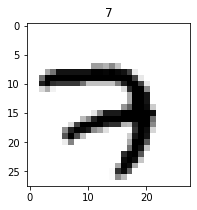

In [6]:
plot_data(mnist.train.images[0],np.argmax(mnist.train.labels[0]))

### plot multiple images

In [7]:
def plot_multiple_images(images,labels,prediction,idx,num=10):
    plt.figure(figsize=(14,12))
    if num>25: num=25
    for i in range(num):
        plt.subplot(5,5,i+1)
        plt.imshow(np.reshape(images[idx],(28,28)),cmap='binary')
        title = "label : " + str(np.argmax(labels[idx]))
        if len(prediction)>0:
            title += ",predict : "+str(prediction[idx])
        plt.title(title)
        plt.xticks([]);plt.yticks([])
        idx+=1
    plt.show()

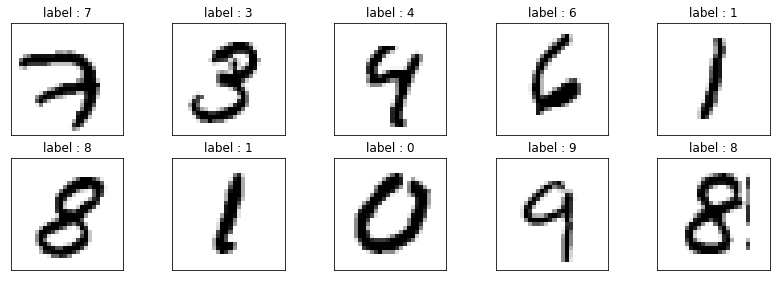

In [8]:
plot_multiple_images(mnist.train.images, mnist.train.labels, [],0)

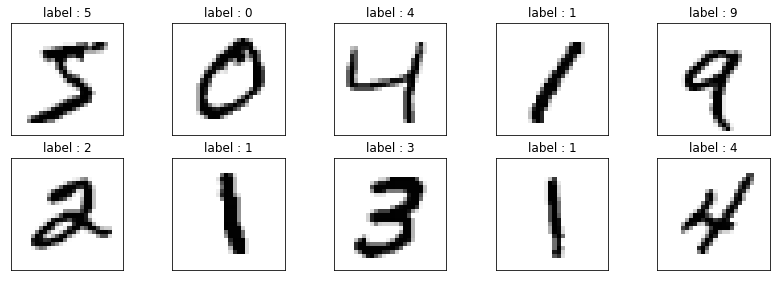

In [9]:
plot_multiple_images(mnist.validation.images, mnist.validation.labels, [],0)

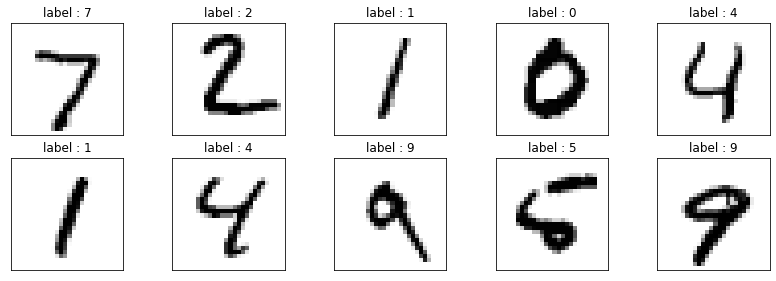

In [10]:
plot_multiple_images(mnist.test.images, mnist.test.labels, [],0)

In [11]:
# 批次讀取資料，每次只讀取 100 筆

batch_images_xs, batch_labels_ys = mnist.train.next_batch(batch_size=100)

In [12]:
print('batch images : ',batch_images_xs.shape)
print('batch labels : ',batch_labels_ys.shape)

batch images :  (100, 784)
batch labels :  (100, 10)


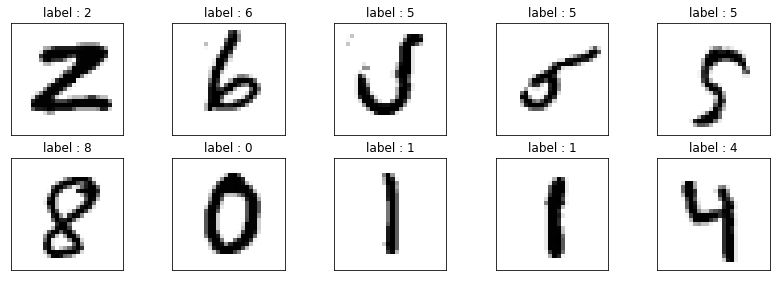

In [13]:
plot_multiple_images(batch_images_xs,batch_labels_ys,[],0)

## <font color='dark'>Build the model</font>

不同於 keras 的 model Sequession，我們必須先自行定義 layer 的函數才能建立一層層模型

In [14]:
def layer(output_dim, input_dim, inputs, activation=None):
    w = tf.Variable(tf.random_normal([input_dim,output_dim]))
    b = tf.Variable(tf.random_normal([1,output_dim]))
    xwb = tf.matmul(inputs,w)+b
    if activation is None:
        outputs = xwb
    else:
        outputs = activation(xwb)
    return outputs

接下來我們就來一層層堆我們的 model

In [15]:
# 首先建立輸入層
X = tf.placeholder('float',[None,784])

In [16]:
# 再來建立隱藏層
h1 = layer(output_dim=1000,input_dim=784,inputs=X,activation=tf.nn.relu)

In [17]:
# 再來建立第二層隱藏層
h2 = layer(output_dim=1000,input_dim=1000,inputs=h1,activation=tf.nn.relu)

In [18]:
# 最後建立輸出層
y_predict = layer(output_dim=10,input_dim=1000,inputs=h2)

### Define the training way

不像 keras 只要使用 model.compile 填 loss function、optimizer、評估模型方式 就好<br>
tensorflow 我們要自己去定義
* loss function 
* optimizer
* 評估模型的方式 (例如:accuracy)

首先我們要先定義資料的 label 真實值

In [19]:
y_label = tf.placeholder("float",[None,10])

**定義 loss function**

In [20]:
# reduce_mean : 將下列 cross entropy 計算結果 做 平均
# logist : 參數為預測值 ; labels : 參數為真實質

loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_predict,labels=y_label))

**定義 optimizer**

In [21]:
# optimizer 使用 loss(誤差) 來更新模型的 權重(weight) 和 偏差(bias)，使 誤差(loss) 最小化

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_function)

接下來我們定義評估模型的方式 --> Accuracy

**去計算每一筆資料是否正確**

In [22]:
# 用 tf.equal 來判斷(真實值)與(預測值)是否相等，相等回傳 1，不同回傳 0
# 因為我們用 Onehot encoding 來 label ， 所以使用 tf.arg_max 來轉換成數字

correct_prediction = tf.equal( tf.argmax(y_label,1),tf.argmax(y_predict,1) )

In [23]:
# 先用 tf.cast 轉換型式成 float，再將所有 結果(每筆資料不是0就是1) 做平均

accuracy = tf.reduce_mean( tf.cast(correct_prediction,"float") )

## <font color='dark'>Train the model</font>

Tensorflow 必須撰寫程式碼來放入資料進去訓練模型，首先我們必須來定義訓練的參數

In [24]:
trainEpochs = 15  # 訓練 15 次的週期
batchSize = 100   # 每一批次的資料量為 100

# total batch 是算每一次的訓練週期(epoch)，需要有多少批次，我們每一批次是 100，就總數除以100
total_batch = int(mnist.train.num_examples)/batchSize  

loss_list = []; epoch_list = []; accuracy_list = [];   # 紀錄 誤差 與 準確率

from time import time  # 去計算訓練時間用的
startTime = time()

In [25]:
total_batch

550.0

定義完之後，開始進行訓練

In [26]:
# 建立 tensorflow session 和 起使化 tensorflow global 變數
sess = tf.Session()   
sess.run(tf.global_variables_initializer())

for epoch in range(trainEpochs):
    for i in range(int(total_batch)):
        batch_x, batch_y = mnist.train.next_batch(batchSize)           # 將資料批次輸入，每一批次為 100 筆資料
        sess.run(optimizer,feed_dict={X:batch_x, y_label:batch_y})     # 最佳化的方式依照誤差值來調整 weight 和 bias
    
    # 所有批次訓練之後，我們使用 驗證的資料 來去算這次 epoch 的 誤差 和 準確率
    loss,acc = sess.run( [loss_function,accuracy],feed_dict={X:mnist.validation.images,y_label:mnist.validation.labels} )
    
    epoch_list.append(epoch)
    loss_list.append(loss)
    accuracy_list.append(acc)
    print('Train Epoch : ',\
          '%0.2d'%(epoch+1),\
          "Loss : ",\
          "%0.5f"%(loss),\
          "Accuracy : ",acc)

duration = time()-startTime
print("Train Finished takes : %0.3f sec"%duration)

Train Epoch :  01 Loss :  142.27548 Accuracy :  0.91400003
Train Epoch :  02 Loss :  87.45808 Accuracy :  0.93820006
Train Epoch :  03 Loss :  74.57784 Accuracy :  0.94600004
Train Epoch :  04 Loss :  75.64433 Accuracy :  0.9426001
Train Epoch :  05 Loss :  54.91997 Accuracy :  0.957
Train Epoch :  06 Loss :  58.17215 Accuracy :  0.95620006
Train Epoch :  07 Loss :  56.14081 Accuracy :  0.95680004
Train Epoch :  08 Loss :  57.57777 Accuracy :  0.95580006
Train Epoch :  09 Loss :  60.01083 Accuracy :  0.957
Train Epoch :  10 Loss :  55.39816 Accuracy :  0.9642
Train Epoch :  11 Loss :  54.07783 Accuracy :  0.96360004
Train Epoch :  12 Loss :  52.45966 Accuracy :  0.96540004
Train Epoch :  13 Loss :  56.71542 Accuracy :  0.96140003
Train Epoch :  14 Loss :  58.44020 Accuracy :  0.96540004
Train Epoch :  15 Loss :  48.45283 Accuracy :  0.96760005
Train Finished takes : 48.429 sec


## <font color='dark'>Show the accuracy</font>

In [27]:
print("Accuracy : ",sess.run(accuracy,feed_dict={X:mnist.test.images,y_label:mnist.test.labels}))

Accuracy :  0.9667


## <font color='dark'>Predict the result</font>

In [28]:
prediction_result = sess.run( tf.argmax(y_predict,1),feed_dict={X:mnist.test.images}  )

Instructions for updating:
Use `argmax` instead


In [29]:
# 我們可以看到前 10 筆的預測結果

prediction_result[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

我們可以去調整 hidden layer 的神經元數，也可以多加幾層 hidden layer，來看看怎麼調對 accuracy 